# Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that used has been provided by  Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Load the Data

There are four files associated with this project (not including this one):

- `AZDIAS_Subset_1.csv`, `AZDIAS_Subset_2.csv`, `AZDIAS_Subset_3.csv`& `AZDIAS_Subset_4.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

- Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood.
- We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters.
- The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase.  -  - This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
from glob import glob
files = glob("data_main/AZDIAS_Subset_*.csv")
azdiaz = pd.concat([pd.read_csv(file, sep=',', index_col=0, low_memory=False) for file in files])

# Load in the feature summary file.
feat_info = pd.read_csv('data_main/AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('\033[1m' + '************************AZDIAS Data Information**************************' + '\033[0m\n')
print('\033[1m' + '-----------------DESCRIBE : MEAN, MEDIAN, MODE, QUARTILES----------------' + '\033[0m\n')
print(azdiaz.describe())
print('\n')
print('\033[1m' + '-----------------------INFO : COUNTS and DATA TYPE-----------------------' + '\033[0m\n')
print(azdiaz.info())
print('\n')
print('\033[1m' + '------------------------------AZDIAS INFO--------------------------------' + '\033[0m\n')
print(azdiaz.head())
print('\n')
print("=="*37)

************************AZDIAS Data Information**************************

-----------------DESCRIBE : MEAN, MEDIAN, MODE, QUARTILES----------------

            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean       

In [4]:
print('\033[1m' + '******************************Feature Summary*****************************' + '\033[0m\n')
print('\033[1m' + '------------------DESCRIBE : COUNT, UNIQUE, TOP, FREQUENCY----------------' + '\033[0m\n')
print(feat_info.describe())
print('\n')
print('\033[1m' + '-----------------------INFO : COUNTS and DATA TYPE------------------------' + '\033[0m\n')
print(feat_info.info())
print('\n')
print('\033[1m' + '------------------------------FEATURE INFO--------------------------------' + '\033[0m\n')
print(feat_info.head())
print('\n')
print("=="*37)

******************************Feature Summary*****************************

------------------DESCRIBE : COUNT, UNIQUE, TOP, FREQUENCY----------------

              attribute information_level     type missing_or_unknown
count                85                85       85                 85
unique               85                 9        5                  9
top     LP_FAMILIE_FEIN            person  ordinal               [-1]
freq                  1                43       49                 26


-----------------------INFO : COUNTS and DATA TYPE------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.8+ KB
None


------------------------------FEATURE INFO--------------------------------

              attribute informa

## Preprocessing

### Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help you make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feature_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing.


In [5]:
# Identify missing or unknown values in azdiaz and convert them to NaNs.
"""
if azdias.columns match feat_info rows and azdias.column.value is in the feat_info.missing_or_unknown,
   replace old with np.nan
"""
for ac in azdiaz.columns:
    NaN_list =feat_info.loc[feat_info['attribute'] == ac,'missing_or_unknown'].tolist()[0]
    NaN_list_str = NaN_list.strip('[]').split(',')
    if NaN_list_str[0] != '':
        # Considering float values in azdiaz
        try:
            NaN_list_tmp=[]
            for i in NaN_list_str:
                if pd.api.types.is_number(eval(i)):
                    NaN_list_tmp.append(str(float(i)))
                   
        except:
            next
        NaN_list_str += NaN_list_tmp
        azdiaz.loc[azdiaz[ac].astype(str).isin(NaN_list_str),ac]=np.nan


There are a few columns that are outliers in terms of the proportion of values that are missing. We can use a histogram to visualize the distribution of missing value counts to find these columns.

In [6]:
# Perform an assessment of how many missing data points are there in each column of azdiaz dataset
def assess_missing_data(azdiaz):
    rec = []
    for col in azdiaz.columns:
        miss_count = azdiaz[col].isnull().sum()
        miss_percent = miss_count/azdiaz.shape[0]
        rec.append([col, miss_count, miss_percent*100])
    miss_brief = pd.DataFrame(rec, columns=['Features', 'Missing Count', 'Missing Percentage'])
    return miss_brief.sort_values('Missing Percentage', ascending=False)

azdiaz_miss_stats = assess_missing_data(azdiaz)

azdiaz_miss_stats.head(60)

,Features,Missing Count,Missing Percentage
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699
70,KKK,158064,17.735668
73,REGIOTYP,158064,17.735668
48,W_KEIT_KIND_HH,147988,16.605084
60,KBA05_ANTG1,133324,14.959701


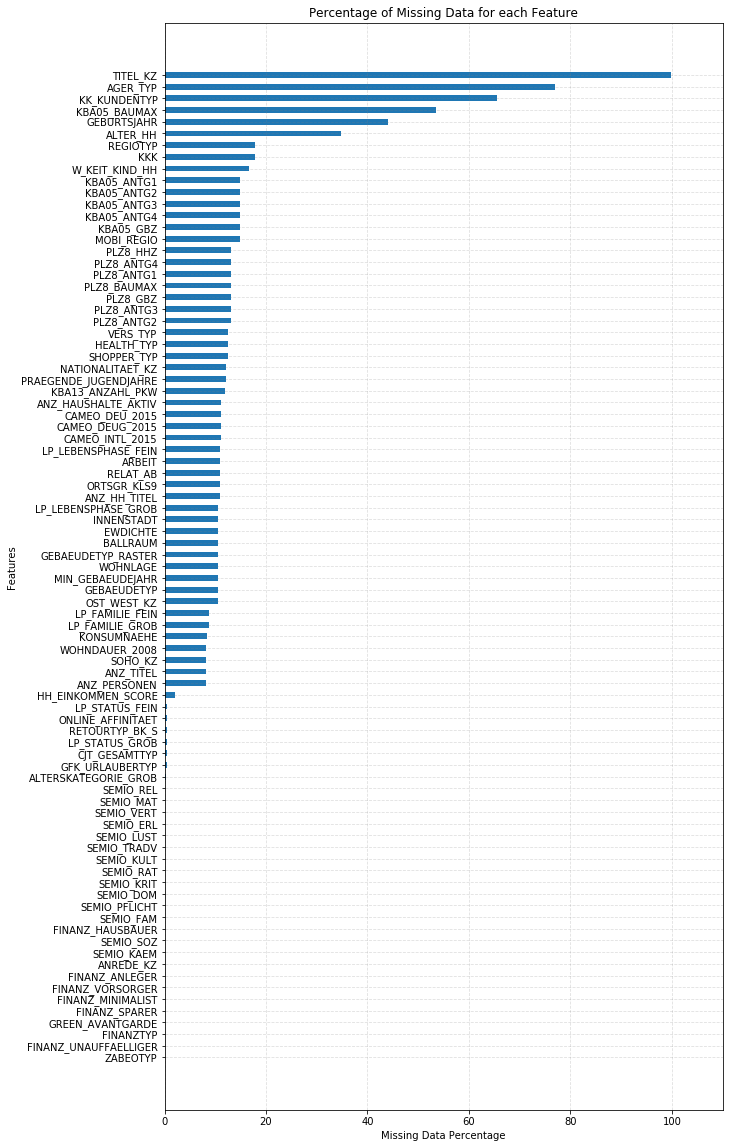

In [15]:
# Investigate patterns in the amount of missing data in each column.
fig, ax = plt.subplots(figsize=(10, 20))

azdiaz_miss_plot = azdiaz_miss_stats.sort_values('Missing Percentage', ascending=True)

pos = np.arange(len(azdiaz_miss_stats))

ax.barh(pos, azdiaz_miss_plot['Missing Percentage'],
                 align='center',
                 height=0.5,
                 tick_label=azdiaz_miss_plot['Features'])

ax.set_xlim([0, 110])
ax.xaxis.grid(True, linestyle='--', which='major',
               color='grey', alpha=.25)
ax.yaxis.grid(True, linestyle='--', which='major',
               color='grey', alpha=.25)
plt.title("Percentage of Missing Data for each Feature")
plt.xlabel("Missing Data Percentage")
plt.ylabel("Features");
plt.show()

In [9]:
# Remove the outlier columns i.e. columns with high percentage of missing values.

# set threshold
drop_col_thresh = 30
features_to_drop = azdiaz_miss_stats[azdiaz_miss_stats['Missing Percentage'] >= drop_col_thresh]
features_to_drop.head(10)

,Features,Missing Count,Missing Percentage
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699


In [10]:
# Drop columns above threshold
azdiaz.drop(features_to_drop['Features'], axis=1, inplace=True)
azdiaz.shape

(891221, 79)

In [21]:
# Condition to find target atrribute in feat_info
removed_condition = feat_info['attribute'].isin(features_to_drop['Features'].tolist())
feat_info_removed_outlier=feat_info.loc[~removed_condition]
feat_info_removed_outlier

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [24]:
def Check_value_in_Nan_list(azdias,feat_info,count_name):
    '''Input: 
       count_name: one exited feature name
    '''
    if count_name in azdiaz.columns.tolist():
        print(azdiaz[count_name].value_counts()) 
        print(feat_info[feat_info['attribute'] == count_name].head())
    else:
        print("{} doesn't exist in azdias".format(count_name))

Check_value_in_Nan_list(azdiaz,feat_info,'ANREDE_KZ')

2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64
   attribute information_level         type missing_or_unknown
2  ANREDE_KZ            person  categorical             [-1,0]




Many columns in dataset have missing data. We have set the missing data threshold percent as 30. The following columns have missing data more than the threshold -


|  Serial | attribute | miss_count | miss_percent | feature description |
| --- | --- | --- | --- | --- |
| 40 |	TITEL_KZ|889061|99.757636|Academic title flag |
| 0 | AGER_TYP|685843|76.955435|Person type for elderly |
| 47 |	KK_KUNDENTYP|584612|65.596749|Consumer pattern in last 6 months |
| 64 |	KBA05_BAUMAX|476524|53.468668|Most common building type within the microcell |
| 11 |	GEBURTSJAHR|392318|44.020282|Year of birth |
| 43 | 	ALTER_HH|310267|34.813699|Birthdate of head of household |

These features have miss percent over 30 percent while all other features are under 20 percent, making these features clear outliers. These columns were hence deleted from the data set.

Looking at some patterns in missing values we can notice that:

1)LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB, LP_FAMILIE_FEIN & LP_FAMILIE_GROB,LP_STATUS_FEIN & lP_STATUS_GROB, CAMEO_DEUG_2015 & CAMEO_DEU_2015& CAMEO_INTL_2015 have same number of missing values. They represent similar information but in different scale, maybe we can just keep one.

2)KBA05_ANTG1& KBA05_ANTG2 & KBA05_ANTG3& KBA05_ANTG4 have same number of missing values.They represent the information in the same geographical location. Same as PLZ8_ANTG1 & PLZ8_ANTG2 & PLZ8_ANTG3 & PLZ8_ANTG4 PLZ8_BAUMAX & PLZ8_HHZ&PLZ8_GBZ

#### Assess Missing Data in Each Row


In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups.

In [ ]:
# Row wise missing data in the dataset

missing_row_data = azdias.isnull().sum(axis=1)
missing_row_data.hist(bins = 20)
plt.title("The number of  missing row data " );


From examing the chart above, it appears there are a large group of rows with less than 20 missing values 
and a second group of rows with more than 30 missing values. So the threshold will be 30.

In [ ]:
"""
Removing rows above threshold missing data
"""
row_thereshold = 30
#count NaN by row, set condition that is less than row_thereshold
condition = azdias.isnull().sum(axis=1) < row_thereshold
#print(azdias.isnull().sum(axis=1) < row_thereshold)
azdias_below30 = azdias[condition]
azdias_above30 = azdias[~condition]

azdias_below30.head(10)

Lets look at the distribution of some variables across both data subsets -  with more than 30% missing column values and with below 30% missing columns.

This allows us to know if we are taking a representative data set for further process, after dropping the sparse rows.

In [ ]:

selected_features =['ZABEOTYP','ANREDE_KZ','ALTERSKATEGORIE_GROB',\
    'ONLINE_AFFINITAET', 'NATIONALITAET_KZ' ,'FINANZ_UNAUFFAELLIGER','SEMIO_REL']
for i, col in enumerate(selected_features):
    plt.figure(figsize=(10,8))
    sns.distplot(azdias_below30[col][azdias_below30[col].notnull()].astype(float), label='below')
    sns.distplot(azdias_above30[col][azdias_above30[col].notnull()].astype(float), label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();


In [ ]:
# prepare feature distribution data for analysis
azdias_below30_stat= azdias_below30[selected_features][azdias_below30[selected_features].notnull()].describe().T
azdias_below30_stat.columns=['count_b','mean_b','std_b','min_b','25%_b','50%_b','75%_b','max_b']
features = azdias_below30_stat.index.tolist()
azdias_below30_stat.insert(0,'feature',features)
azdias_above30_stat= azdias_above30[selected_features][azdias_above30[selected_features].notnull()].describe().T
azdias_above30_stat.columns=['count_a','mean_a','std_a','min_a','25%_a','50%_a','75%_a','max_a']
features = azdias_above30_stat.index.tolist()
azdias_above30_stat.insert(0,'feature',features)
azdias_stat=azdias_below30_stat.merge(azdias_above30_stat,on='feature')
azdias_stat.head(15)

In [ ]:
# check if feature distribution different in azdias_above30 is greater than 1 standard deviation of azdias_below30.

condition=(azdias_stat['mean_a']-azdias_stat['mean_b'])/azdias_stat['std_b'] > 1
azdias_stat.loc[condition,['feature','mean_b','mean_a']].head()

#### Assess Missing Data in Each Row


Dataset has 3 groups for a number of NaNs in a row.

* Group 1 has a few NaNs ( in 0~10 columns per row)
* Group 2 has a small number of NaNs (in 10~30 columns per row)
* Group 3 has a large number of NaNs (more than 30 columns per row)

The following features distribution in subset with lots of missing values looks similar with one in subset with few or no missing values base above analysis.

- ZABEOTYP
- ANREDE_KZ
- ALTERSKATEGORIE_GROB
- ONLINE_AFFINITAET
- NATIONALITAET_KZ

The following features distribution in subset with lots of missing values looks much different than one in subset with few or no missing values.

- FINANZ_UNAUFFAELLIGER: UNAUFFAELLIGER means inconspicuous; the outlier spike in "5" buckets
- SEMIO_REL: the outlier spike in "7" buckets that means lowest affinity associated with personality

Therefore, we can use conclude that these two populations are quite distinct from each other. In the following analysis, we will seperate the data with row missing values above the threshold to a dataset, and only focus on studying the majority group with small or few missing values.

### Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. W can check the third column of the feature summary (`feat_info`) for a summary of types of measurement.

- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling is necessary for remaining two variable types: categorical, and 'mixed'.

We examine categorical and mixed-type features and make a decision on each of them, whether we to keep, drop, or re-encode each. 

Then we will create a new data frame with only the selected and engineered columns.

In [ ]:
# Checking the count of each type of features
print(feat_info_removed_outlier['type'].value_counts())


In [ ]:
feat_info['type'].value_counts().plot(kind='barh');

#### Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. with [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
categorical_list=feat_info_removed_outlier.loc[feat_info['type'] == 'categorical', 'attribute'].tolist()
categorical_list
azdias[categorical_list].head(10)

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Get need encode features list with categorical type
non_numeric_binary_list = ['OST_WEST_KZ']
binary_list = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']
multi_list = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
         'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
        'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
No_need_encode_catlist=['GREEN_AVANTGARDE','SOHO_KZ','OST_WEST_KZ']
Need_encode_catlist=list(set(categorical_list)-set(No_need_encode_catlist))
Need_encode_catlist


impute the most frequent value for the missing data in each column

In [ ]:
def impute_NaN_with_Most_freq_value(df, feature):
    '''
    input: 
            df: input dataframe to be imputed
            feature: the column from the dataframe you want to perform imputation
    '''
    # find most frequent category
    most_frequent_category = df.groupby([feature])[feature].count().sort_values(ascending=False).index[0]
    # replace NaN
    df[feature].fillna(most_frequent_category, inplace=True )
    
    
NaN_cols = azdias_below30.columns[azdias.isnull().any()].tolist()
for col in NaN_cols:
    impute_NaN_with_Most_freq_value(azdias_below30, col)
    print("replacing the NaN with most frequent value in column: ", col)

Verifying the result

In [ ]:
def check_NaN(df):
    print('How many NaN does all columns of the current dataset have ? : {} '.format(df.isnull().any().sum()))
check_NaN(azdias_below30)

In [ ]:
#one hot encoder for features with categorical 
azdias_below30_encode=pd.get_dummies(azdias_below30, prefix=Need_encode_catlist, columns=Need_encode_catlist )

In [ ]:
azdias_below30_encode['OST_WEST_KZ'].value_counts()

In [ ]:
#Replace OST_WEST_KZ non-numeric values with numeric values:
azdias_below30_encode.loc[azdias_below30_encode['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 1
azdias_below30_encode.loc[azdias_below30_encode['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 0
print(azdias_below30_encode[['OST_WEST_KZ']].describe())
print(azdias_below30_encode['OST_WEST_KZ'].value_counts())

####  Re-Encode Categorical Features

####  Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we can create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up of two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables, however for the purposes of this project, is equivalent to just treating them as their raw numeric values.


In [ ]:
def create_feature(df,source_feature, map_dict):
    '''
    Input:
     df: source dataframe
     source_feature: one source feature that is data source for new feature. It doesn't support a mutliple features.
     map_dict: It includes the mapping dictionary between the data of source feature and new feature
    return:
     new_df: the new df include new feature data after convert data based on source_feature
    '''
    new_df = df[source_feature].astype(np.int).replace(map_dict)
    return new_df

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Assess mix variables
mix_list=feat_info_removed_outlier.loc[feat_info['type'] == 'mixed', 'attribute'].tolist()
# Investigate "PRAEGENDE_JUGENDJAHRE" 
PRAEGENDE_JUGENDJAHRE_decade_mapping = {
    1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 
    9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6
}
azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_DECADE'] = create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE', 
                                                                       PRAEGENDE_JUGENDJAHRE_decade_mapping)

#0 for mainstream, and 1 for avantgarde
PRAEGENDE_JUGENDJAHRE_movement_mapping = {
    1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 
    9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1
}
azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE', 
                                                                       PRAEGENDE_JUGENDJAHRE_movement_mapping)
mixed_categorical_list=['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_below30_encode['CAMEO_INTL_2015_WEALTH'] = azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
azdias_below30_encode['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10)) 
mixed_ordinal_list=['CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE_STAGE']

In [ ]:
# sanity check on PRAEGENDE_JUGENDJAHRE mapping
check_NaN(azdias_below30_encode)
azdias_below30_encode[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']].head()

In [ ]:
Check_value_in_Nan_list(azdias,feat_info_removed_outlier,'WOHNLAGE')

In [ ]:
# Rural: Rural -> 1.0, Not Rural -> 2.0
WOHNLAGE_rural_mapping = {
    0: 2, 1: 2,  2: 2,  3: 2,
    4: 2, 5: 2,  7: 1,  8: 1
}
azdias_below30_encode['WOHNLAGE_RURAL'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_rural_mapping)
mixed_categorical_list.append('WOHNLAGE_RURAL')
# Neighborhood quality, Very good neighborhood -> 6.0, Good neighborhood -> 5.0, Average neighborhood -> 4.0, 
# Poor neighborhood -> 3.0, Very poor neighborhood -> 2.0, Unknown -> 1.0
WOHNLAGE_neighborhood_mapping = {
    0: 1, 1: 6, 2: 5, 3: 4,
    4: 3, 5: 2, 7: 1, 8: 1
}
azdias_below30_encode['WOHNLAGE_NEIGHBORHOOD'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_neighborhood_mapping)
mixed_ordinal_list.append('WOHNLAGE_NEIGHBORHOOD')

In [ ]:
Check_value_in_Nan_list(azdias,feat_info_removed_outlier,'PLZ8_BAUMAX')

In [ ]:
# Investigate "PLZ8_BAUMAX", It is an ordinal feature
# 1-4   as 1-4 (homes),  5   as 0 
PLZ8_BAUMAX_homes_mapping = {
    1: 1, 2: 2, 3: 3,
    4: 4, 5: 0
}

# 1-4 as 0 (non-business),    5 as 1(business)
PLZ8_BAUMAX_business_mapping = {
    1: 0, 2: 0, 3: 0,
    4: 0, 5: 1
}
azdias_below30_encode['PLZ8_BAUMAX_HOMES'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_homes_mapping)
azdias_below30_encode['PLZ8_BAUMAX_BUSINESS'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_business_mapping)
mixed_ordinal_list.append('PLZ8_BAUMAX_BUSINESS')
mixed_categorical_list.append('PLZ8_BAUMAX_BUSINESS')

In [ ]:
#categorical convert to one hot variable
Not_need_binary_encode_list=['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT','PLZ8_BAUMAX_BUSINESS']
Need_binary_encode_list=list(set(mixed_categorical_list)-set(Not_need_binary_encode_list))
azdia_mixed_OHE=pd.get_dummies(azdias_below30_encode[Need_binary_encode_list].astype(np.object))
azdia_mixed_OHE.head()


In [ ]:
# Ordinal features are converted into numeric.
azdias_below30_encode.loc[:,mixed_ordinal_list] = azdias_below30_encode[mixed_ordinal_list].astype(np.float)
# Drop the four original features
azdias_below30_encode.drop(mix_list, axis = 1, inplace = True)
print("\n The new dataset dimension is: {}".format(azdias_below30_encode.shape))

####  Engineer Mixed-Type Features


The mixed features are listed as follows:

* LP_LEBENSPHASE_FEIN: Life stage, fine scale
* LP_LEBENSPHASE_GROB: Life stage, rough scale
* PRAEGENDE_JUGENDJAHRE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
* WOHNLAGE: Neighborhood quality (or rural flag)
* CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code
* PLZ8_BAUMAX: Most common building type within the PLZ8 region

The following features are selected and converted:

* PRAEGENDE_JUGENDJAHRE is converted into two categorical features (movement or decade)
* CAMEO_INTL_2015 is converted into two oridnal features (wealth or life stage)
* WOHNLAGE is converted into categorical or ordinal features (rural or neighborhood quality)
* PLZ8_BAUMAX: is converted into categorical or ordinal features (homes or business quality)

The following features are not selected.

* LP_LEBENSPHASE_FEIN: Life stage is already included by CAMEO_INTL_2015
* LP_LEBENSPHASE_GROB: Life stage is already included by CAMEO_INTL_2015


#### Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. The dataframe should consist of the following:

- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Making sure that for any new columns that we have engineered, that we've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, we should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features we created should be retained.

In [ ]:
azdias_below30_encode=azdias_below30_encode.join(azdia_mixed_OHE)
print(azdias_below30_encode.shape)
for c in azdias_below30_encode.columns:
    print(c)

###  Create a Cleaning Function

We can create a function to do all the cleaning processing above with a single call. This would help to process new data points into our pipeline.

In [ ]:
def clean_data(df, feat_info, df_drop_cols_sync=None ):
    """
    Perform feature trimming, re-encoding, and engineering for demographicsdata
    INPUT: 
        df: Demographics DataFrame and Feature infomation DataFrame with a count of nan.
        df_drop_cols_sync: It will used in the other dataset that need to compared with the cleaned demographics DataFrame
    OUTPUT: 
       Trimmed and cleaned demographics DataFrame
    """

    azdias=df
    # Identify missing or unknown data values and convert them to NaNs.
    """
    if azdias.columns match feat_info.columns and azdias.column.value is in the feat_info.missing_or_unknown,
       replace old with np.nan
    """
    for ac in azdias.columns:
        NaN_list =feat_info.loc[feat_info['attribute'] == ac,'missing_or_unknown'].tolist()[0]
        NaN_list_str = NaN_list.strip('[]').split(',')
        if NaN_list_str[0] !='':
            # some feature may be float format, so add float format string for number value except the string value
            try:
                NaN_list_tmp=[]
                for i in NaN_list_str:
                    if pd.api.types.is_number(eval(i)):
                        NaN_list_tmp.append(str(float(i)))
            except:
                # if eval find that i is a string, the except part will bypass it.
                next
            NaN_list_str += NaN_list_tmp
            azdias.loc[azdias[ac].astype(str).isin(NaN_list_str),ac]=np.nan
            
            
            
    # remove selected columns and rows, ...
    # remove selected columns         
    # Perform an assessment of how much missing data there is in each column of the dataset.
    rec = []
    for column_name in azdias.columns:
        miss_count = azdias[column_name].isnull().sum(axis=0)
        miss_percent=miss_count/azdias.shape[0]
        rec.append([column_name,miss_count,miss_percent*100])
    azdias_stats = pd.DataFrame.from_records(rec, columns = ['attribute', 'miss_count','miss_percent'])  
    azdias_stats = azdias_stats.sort_values('miss_percent',axis=0, ascending = False )
    
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)

    if df_drop_cols_sync is not None:  
        #if the columns in adias is dropped , and they also must be dropped in the comparative dataset
        feature_to_drop = df_drop_cols_sync
    else:
        drop_col_threshold = 30
        feature_to_drop= azdias_stats.loc[azdias_stats['miss_percent'] >= drop_col_threshold]
        print("Drop these columns : {}".format(feature_to_drop.attribute.tolist()) )
        print(feature_to_drop.head(10))
    
    # removed data due to lots missing data in the column
    azdias.drop(feature_to_drop.attribute, axis=1, inplace = True) 
    # condition to find target atrribute in feat_info
    removed_condition = feat_info['attribute'].isin(feature_to_drop.attribute.tolist())
    feat_info_removed_outlier=feat_info.loc[~removed_condition]
    
    
    # remove selected  rows, ...
    """
    From examing the data, it appears there are a large group of rows with less than 20 missing values 
    and a second group of rows with more than 30 missing values. So the threshold will be 30.
    """
    row_thereshold = 30
    #count NaN by row, set condition that is less than row_thereshold
    condition = azdias.isnull().sum(axis=1) < row_thereshold
    azdias_below30 = azdias[condition]
    azdias_above30 = azdias[~condition]


    # select, re-encode, and engineer column values.
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical_list=feat_info_removed_outlier.loc[feat_info['type'] == 'categorical', 'attribute'].tolist()
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    #Get need encode features list with categorical type
    non_numeric_binary_list = ['OST_WEST_KZ']
    binary_list = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']
    multi_list = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
             'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
            'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    No_need_encode_catlist=['GREEN_AVANTGARDE','SOHO_KZ','OST_WEST_KZ']
    Need_encode_catlist=list(set(categorical_list)-set(No_need_encode_catlist))
     
    #impute the most frequent value for the missing data in each column 
    NaN_cols = azdias_below30.columns[azdias.isnull().any()].tolist()
    for col in NaN_cols:
        impute_NaN_with_Most_freq_value(azdias_below30, col)
    
    #one hot encoder for features with categorical 
    azdias_below30_encode=pd.get_dummies(azdias_below30, prefix=Need_encode_catlist, columns=Need_encode_catlist )
    
    #Replacing non numerical binary variable with numerical values
    azdias_below30_encode.loc[azdias_below30_encode['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 1
    azdias_below30_encode.loc[azdias_below30_encode['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 0

    # Assess mix variables
    mix_list=feat_info_removed_outlier.loc[feat_info['type'] == 'mixed', 'attribute'].tolist()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.                                                   
    # 1 stands for 40s, 2 for 50s, 3 for 60s, 4 for 70s, 5 for 80s and 6 for 90s                                            
    PRAEGENDE_JUGENDJAHRE_decade_mapping = {                                                                                
        1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4,                                                                             
        9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6                                                                             
    }                                                                                                                       
    azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_DECADE'] = \
        create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE', PRAEGENDE_JUGENDJAHRE_decade_mapping)            
                                                                                                                            
    #0 for mainstream, and 1 for avantgarde                                                                                 
    PRAEGENDE_JUGENDJAHRE_movement_mapping = {                                                                              
        1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0,                                                                             
        9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1                                                                             
    }                                                                                                                       
    azdias_below30_encode['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = \
        create_feature(azdias_below30_encode,'PRAEGENDE_JUGENDJAHRE',PRAEGENDE_JUGENDJAHRE_movement_mapping)          
    mixed_categorical_list=['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']   
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.                                                                                                        
    azdias_below30_encode['CAMEO_INTL_2015_WEALTH'] = \
        azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
    azdias_below30_encode['CAMEO_INTL_2015_LIFE_STAGE'] = \
        azdias_below30_encode['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10)) 
    mixed_ordinal_list=['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']
    
    # Rural: Rural -> 1.0, Not Rural -> 2.0                                                                                                                                                     
    WOHNLAGE_rural_mapping = {                                                                                                      
        0: 2, 1: 2,  2: 2,  3: 2,                                                                                                   
        4: 2, 5: 2,  7: 1,  8: 1                                                                                                    
    }                                                                                                                               
    azdias_below30_encode['WOHNLAGE_RURAL'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_rural_mapping)              
    mixed_categorical_list.append('WOHNLAGE_RURAL')                                                                                 
    # Neighborhood quality, Very good neighborhood -> 6.0, Good neighborhood -> 5.0, Average neighborhood -> 4.0,                   
    # Poor neighborhood -> 3.0, Very poor neighborhood -> 2.0, Unknown -> 1.0                                                       
    WOHNLAGE_neighborhood_mapping = {                                                                                               
        0: 1, 1: 6, 2: 5, 3: 4,                                                                                                     
        4: 3, 5: 2, 7: 1, 8: 1                                                                                                      
    }                                                                                                                               
    azdias_below30_encode['WOHNLAGE_NEIGHBORHOOD'] = create_feature(azdias_below30_encode,'WOHNLAGE', WOHNLAGE_neighborhood_mapping)
    mixed_ordinal_list.append('WOHNLAGE_NEIGHBORHOOD')
    
    # Investigate "PLZ8_BAUMAX", It is already　the ordinal feature                                                                                                                                                
    # 1-4   as 1-4 (homes),  5   as 0                                                                                                
    PLZ8_BAUMAX_homes_mapping = {                                                                                                    
        1: 1, 2: 2, 3: 3,                                                                                                            
        4: 4, 5: 0                                                                                                                   
    }                                                                                                                                
                                                                                                                                     
    # 1-4 as 0 (non-business),    5 as 1(business)                                                                                   
    PLZ8_BAUMAX_business_mapping = {                                                                                                 
        1: 0, 2: 0, 3: 0,                                                                                                            
        4: 0, 5: 1                                                                                                                   
    }                                                                                                                                
    azdias_below30_encode['PLZ8_BAUMAX_HOMES'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_homes_mapping)      
    azdias_below30_encode['PLZ8_BAUMAX_BUSINESS'] = create_feature(azdias_below30_encode,'PLZ8_BAUMAX', PLZ8_BAUMAX_business_mapping)
    mixed_ordinal_list.append('PLZ8_BAUMAX_BUSINESS')                                                                                
    mixed_categorical_list.append('PLZ8_BAUMAX_BUSINESS')   

    #categorical convert to one hot variable                                                                                                                                 
    Not_need_binary_encode_list=['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT','PLZ8_BAUMAX_BUSINESS']           
    Need_binary_encode_list=list(set(mixed_categorical_list)-set(Not_need_binary_encode_list))      
    azdia_mixed_OHE=pd.get_dummies(azdias_below30_encode[Need_binary_encode_list].astype(np.object))
    # Ordinal features are converted into numeric.
    azdias_below30_encode.loc[:,mixed_ordinal_list] = azdias_below30_encode[mixed_ordinal_list].astype(np.float)

    # Return the cleaned dataframe. 
       
    # Drop the four original features                             
    azdias_below30_encode.drop(mix_list, axis = 1, inplace = True)
    # Add one_hot featurs
    azdias_below30_encode=azdias_below30_encode.join(azdia_mixed_OHE)
    
    return azdias_below30_encode, azdias_above30,feature_to_drop

### Lets test our new function and cleaning pipeline

In [ ]:
#verity clean_data
# Load in the general demographics data.
azdias_1 = pd.read_csv('AZDIAS_Subset_1.csv',sep=',',index_col=0)
azdias_2 = pd.read_csv('AZDIAS_Subset_2.csv',sep=',',index_col=0)
azdias_3 = pd.read_csv('AZDIAS_Subset_3.csv',sep=',',index_col=0)
azdias_4 = pd.read_csv('AZDIAS_Subset_4.csv',sep=',',index_col=0)
azdias = pd.concat([azdias_1,azdias_2,azdias_3,azdias_4],axis=0)
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
#Clean the dataset.
azdias_processed,azdias_outlier, df_drop_cols_sync = clean_data(azdias, feat_info)
# number of population with high NaNs
azdias_NaN_count = azdias.shape[0] - azdias_processed.shape[0]


#### Verification of data being cleaned

In [ ]:
check_NaN(azdias_processed)
print(" number of population with high NaNs is {}".format(azdias_NaN_count))

## Feature Transformation

### Apply Feature Scaling

 - Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

### Impute or drop missing values
- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, make sure that we've cleaned the DataFrame of the remaining missing values.


In [ ]:
# Apply feature scaling to the general population demographics data.
scaler = MinMaxScaler()
azdias_scaled_np = scaler.fit_transform(azdias_processed)
#convert it to DataFrame
azdias_scaled = pd.DataFrame(data=azdias_scaled_np, index=azdias_processed.index, columns=azdias_processed.columns)


In [ ]:
def scale_data(df, scaler):
    # Only transform data by using old fit
    scaled_np= scaler.transform(df)
    #convert it to DataFrame
    return pd.DataFrame(data=scaled_np, index=df.index, columns=df.columns)

###  Perform Dimensionality Reduction


In [ ]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_scaled)

In [ ]:
# Investigate the variance accounted for by each principal component.
def show_var_and_cumvar(pca):
    num_components = len(pca.explained_variance_ratio_)
    indx = np.arange(num_components) + 1 # start with 1
    variance_ratio = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10, 7))

    cumulative_variance_ratio = np.cumsum(variance_ratio)

    plt.bar(indx, variance_ratio)  # add variance_ratio as first y axis, indx is used to x axis.
    plt.title('Explained Variance Per Principal Component')
    plt.ylabel("Variance Explained (%)")
    plt.xlabel("Principal Component")
    plt.grid(True)
    
    plt.twinx()  # add one axis for y axis, indx is used to x axis.
    plt.plot(indx, cumulative_variance_ratio, 'm')
    plt.ylabel("Cumulative Variance Explained (%)")
    
    plt.grid(True)
    plt.show()

show_var_and_cumvar(pca)

The plot shows that more than 80% of the variance can be explained by top 50 features. The remaining features do not contribute to much of variance in the dataset and are flat decaying tail afterwards.

This can be considered as a good threshold where additonal components do not contribute much to the dataset's variance. Thus, 50 principal components will be retained in the following analysis.

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

def do_pca(df, n_com):
    pca_n =PCA(n_components=n_com)
    return pca_n, pca_n.fit_transform(df)
pca_n, np_azdias_scaled_pca_n = do_pca(azdias_scaled, 50)

In [ ]:
show_var_and_cumvar(pca_n)

### Interpretation of PCA resutls

Now that we have our transformed principal components, lets check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Remember, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

Mapping weights for the first principal component to corresponding feature names
 and then print the linked values, sorted by weight.

In [ ]:

def get_sorted_features(df, pca, n_comp):
    #from collections import OrderedDict
    features = df.columns.tolist()
    components = pca.components_[n_comp].tolist()
    weight_map = dict(zip(features, components))
    sorted_features = sorted(weight_map.items(), key=lambda x:x[1])
    return sorted_features

def plot_weights(sorted_features,n_comp):
    df_tmp = pd.DataFrame.from_records(sorted_features,columns=['Features' , 'Weights'])
    ax1=df_tmp.plot.barh(x='Features', y='Weights', figsize=(6, 50), grid=True)
    plt.ylabel('Features')
    plt.xlabel('Weights')
    plt.title('Weights for the ' + str(n_comp) + ' components')
    
    plt.show()
    
def show_weight_and_plot(df, pca, n_com):
    features = get_sorted_features(df, pca, n_com)
    for i in features[:3]:
        print(i) 
    for i in sorted(features, key=lambda x:x[1], reverse= True)[:3]:
        print(i) 
    plot_weights(features,n_com)

In [ ]:
##### Map weights for the First principal  
show_weight_and_plot(azdias_scaled, pca_n, 0)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_weight_and_plot(azdias_scaled, pca_n, 1)


In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_weight_and_plot(azdias_scaled, pca_n, 2)

### Interpreting top Principal Components into component features


<b>The first componet</b>

Top 3 positive features
* FINANZ_MINIMALIST: Financial typology, MINIMALIST means low financial interest.
* KBA05_ANTG1: Number of 1-2 family houses in the microcell
* WOHNLAGE_RURAL_1:rural flag

Top 3 negative features
* LP_STATUS_GROB_1.0: Social status, rough scale low-income earners, 1 means low-income earners.
* CAMEO_INTL_2015_WEALTH: Wealth Typology, mapped to international code.
* PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region

The first component is about middleclass life style and consuming habits.

<b>The second componet</b>

Top 3 positive features
* PRAEGENDE_JUGENDJAHRE_DECADE_6: person's youth , 6 for 90s
* FINANZ_SPARER: Financial typology, SPARER means sparer money
* FINANZ_UNAUFFAELLIGER: Financial typology,UNAUFFAELLIGER: inconspicuous

Top 3 negative features
* ZABEOTYP_3.0: Energy consumption typology, 3 means fair supplied.
* FINANZ_VORSORGER: Financial typology, VORSORGER means be prepared.
* ALTERSKATEGORIE_GROB: Estimated age based on given name analysis.

The second component is about youth/age, generation and their financial status.

<b>The third componet</b>

Top 3 positive features
* ANREDE_KZ_1.0: Gender, 1 means male.
* SEMIO_VERT: Personality typology, VERT means dreamful.
* SEMIO_SOZ: Personality typology, SOZ means socially-minded.

Top 3 negative features
* ANREDE_KZ_2.0: Gender, 2 means female.
* SEMIO_KAEM: Personality typology, KAEM means combative attitude.
* SEMIO_DOM: Personality typology, DOM means dominant-minded

The third component is about personality differences between male and female.



## Clustering

### Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. 

- We use [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.

In [ ]:
# Over a number of different cluster counts...


# run k-means clustering on the data and...
def model_fit(data,max_k_value):
    scores=[]
    centers=list(range(1,max_k_value))
    for i in centers:
        scores.append(get_score(i,data))
    return centers, scores    
    
# compute the average within-cluster distances.
def get_score(center,data):
    kmean=KMeans(n_clusters=center)
    model=kmean.fit(data)
    score=np.abs(model.score(data))
    return score

In [ ]:
centers, scores = model_fit(np_azdias_scaled_pca_n,16)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(centers,scores, linestyle='--', marker='o', color='b');
plt.grid(True)
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 8
km_n = KMeans(n_clusters = n_clusters)
km_model_n = km_n.fit(np_azdias_scaled_pca_n)


In [ ]:
# convert ndarray to dataframe object
azdias_scaled_label = pd.DataFrame({"Cluster_ID": km_model_n.predict(np_azdias_scaled_pca_n)})
df_azdias_scaled_pca = pd.DataFrame(data = np_azdias_scaled_pca_n, \
                                    columns = ['Dim {}'.format(i) for i in range(1,len(pca_n.components_)+1)])
df_azdias_scaled_pca = pd.concat([df_azdias_scaled_pca, azdias_scaled_label],axis =1)
df_azdias_scaled_pca.head(10)

In [ ]:
plt.plot(centers, np.gradient(scores)/np_azdias_scaled_pca_n.shape[0])
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('First Derivative of SSE')
plt.title('SSE Slope vs. Number of Clusters')

Using the elbow method, we have calculated that the data can be divided into 8 clusters. For any additional clusters, the decline in SSE is not major.

### Lets apply the clustering with 8 clusters to the Customer data
First we will need to clean the data using the function we created earlier

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('CUSTOMERS_Subset.csv',sep=';')

In [ ]:
customers.head()

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_processed,customers_outlier,_ = clean_data(customers, feat_info, df_drop_cols_sync)


In [ ]:
customers_processed['CAMEO_DEUG_2015_1.0'] = customers_processed['CAMEO_DEUG_2015_1']
customers_processed['CAMEO_DEUG_2015_2.0'] = customers_processed['CAMEO_DEUG_2015_2']
customers_processed['CAMEO_DEUG_2015_3.0'] = customers_processed['CAMEO_DEUG_2015_3']
customers_processed['CAMEO_DEUG_2015_4.0'] = customers_processed['CAMEO_DEUG_2015_4']
customers_processed['CAMEO_DEUG_2015_5.0'] = customers_processed['CAMEO_DEUG_2015_5']
customers_processed['CAMEO_DEUG_2015_6.0'] = customers_processed['CAMEO_DEUG_2015_6']
customers_processed['CAMEO_DEUG_2015_7.0'] = customers_processed['CAMEO_DEUG_2015_7']
customers_processed['CAMEO_DEUG_2015_8.0'] = customers_processed['CAMEO_DEUG_2015_8']
customers_processed['CAMEO_DEUG_2015_9.0'] = customers_processed['CAMEO_DEUG_2015_9']

In [ ]:
# compare the difference between processed azdia and processed customers.
# if no different, the fit result of azdia can be used for customers.

missing_df = list(set(azdias_processed.columns) - set(customers_processed.columns))
print(missing_df, customers_processed.shape , azdias_processed.shape)

In [ ]:
'''
The customer dataset missed a value of 5 in GEBAEUDETYP feature. 
So we need to add a column GEBAEUDETYP_5.0 with all zeros
when converted to dummy variable, we need to add a column GEBAEUDETYP_5.0 with all zeros.
This column shall be added in place as the dataframe will be converted into a matrix.
'''
for i, c in enumerate(customers_processed.columns.tolist()):
    type(c)
    if c == "GEBAEUDETYP_6.0" or c == "GEBAEUDETYP_6":
        col_position=i
        break
customers_processed.insert(col_position, "GEBAEUDETYP_5.0", np.zeros(customers_processed.shape[0]))

In [ ]:
#verify insert persition of GEBAEUDETYP_6.0
for i, c in enumerate(customers_processed.columns):
    print(i,c)

In [ ]:
azdias_scaled.head()

In [ ]:
# using previous scaler model to process dataset.
customers_scaled = scale_data(customers_processed, scaler)
# using previous pca model to transform dataset.
np_customers_scaled_pca_n = pca_n.transform(customers_scaled)
# using previous Kmean model to predict
customers_scaled_label = pd.DataFrame({"Cluster_ID": km_model_n.predict(np_customers_scaled_pca_n)})
# convert ndarray to dataframe object
df_customers_scaled_pca = pd.DataFrame(data = np_customers_scaled_pca_n, \
                                    columns = ['Dim {}'.format(i) for i in range(1,len(pca_n.components_)+1)])
#combine lable and dimensions
df_customers_scaled_pca = pd.concat([df_customers_scaled_pca, customers_scaled_label],axis = 1)
df_customers_scaled_pca.head()

### Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_azdias_scaled_pca.loc[:,'category']='General_Demographics'
df_customers_scaled_pca.loc[:,'category'] = 'Customer_Demographics'
df_predict_label=pd.concat([df_azdias_scaled_pca,df_customers_scaled_pca])
# Count amount on each category
df_plt=df_predict_label.groupby(['category'])['Cluster_ID'].value_counts().rename('amount')
df_plt=pd.DataFrame(df_plt)
df_plt.reset_index(inplace=True)
# Generate dataset for comparation.
customers_NaN_count=customers.shape[0]-customers_processed.shape[0]
ls = [['Customer_Demographics', n_clusters, customers_NaN_count], ['General_Demographics', n_clusters, azdias_NaN_count]]
for i, (category, cluster_id, amount) in enumerate(ls):
    new_cluster = pd.Series({'category':category,'Cluster_ID': cluster_id,'amount': amount})
    df_plt = df_plt.append(new_cluster, ignore_index=True)
    
# total counts in general population and customer dataset, including the large-NaN data
cust_sum =  df_plt.loc[ df_plt.category == 'Customer_Demographics'].amount.sum( axis = 0)
genl_sum =  df_plt.loc[ df_plt.category == 'General_Demographics'].amount.sum( axis = 0)

# calculate the percentage distribution  
# df_plt.loc[:,'Percentage'] = np.where( df_plt['category']=='Customer_Demographics',  df_plt['amount']/cust_sum*100,  df_plt['amount']/genl_sum*100)
condition_c =  df_plt['category']=='Customer_Demographics'
df_plt.loc[condition_c, 'Percentage'] =  df_plt.loc[condition_c, 'amount']/cust_sum*100
condition_g =  df_plt['category']=='General_Demographics'
df_plt.loc[condition_g, 'Percentage'] =  df_plt.loc[condition_g, 'amount']/genl_sum*100
# Plot the figure for comparation 
fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x='Cluster_ID', y="Percentage", hue='category', data= df_plt)
ax.set_xlabel("Cluster ID", fontsize = 15)
ax.set_ylabel("Percentage (%)", fontsize = 15)
ax.grid()
plt.annotate("Note: Cluster {} represents large NaN data".format(n_clusters), \
        xy=(0.35, 1.02), xycoords='axes fraction', fontsize = 15)

In [ ]:
#The ratio of  customers to general_percent 
df_c=df_plt.loc[condition_c, ['Cluster_ID','Percentage']]
df_c.columns= ['Cluster_ID','Percentage_c']
df_g=df_plt.loc[condition_g, ['Cluster_ID','Percentage']]
df_g.columns= ['Cluster_ID','Percentage_g']
df_m= pd.merge(df_c,df_g, on='Cluster_ID') 
df_m['customers_to_general_percent'] =df_m['Percentage_c']/df_m['Percentage_g']
np_df_m=df_m.sort_values(['Cluster_ID']).values
df_m_sorted=pd.DataFrame(np_df_m, columns=df_m.columns)
df_m_sorted.head(8)

In [ ]:
plt.figure(figsize=(10,6))
x=df_m_sorted.loc[:7,'Cluster_ID']
y=df_m_sorted.loc[:7,'customers_to_general_percent']
plt.plot(x,y)
plt.scatter(x,y)
t1 = np.arange(0.0, float(8), 1)
t2=np.array([1.0]*(8))
plt.plot(t1,t2,'--',linewidth=3)

plt.xticks(np.arange(0,8,1))
plt.xlabel('cluster')
plt.ylabel('Ratio of customer population to general population per cluster')
plt.grid(True)
plt.show()

In [ ]:
# select one overrepresenting cluster, and one underrepresenting cluster
#According above figure , Cluster overrepresenting : 6  ;Cluster underrepresenting :4
centroid_id = [6, 4]
centroids = []
cluster_center = km_n.cluster_centers_[centroid_id,:]
np_inv_pca = pca_n.inverse_transform(cluster_center)
np_inv_scaler = scaler.inverse_transform(np_inv_pca)
df_result = pd.DataFrame(np_inv_scaler ,   columns = azdias_processed.columns, \
                         index = ['co6', 'cu4'])
# Create the dataset for overrepresenting
features=df_result.loc[ ['co6', 'cu4'],:].columns
df_cluster =pd.DataFrame(df_result.loc[ ['co6', 'cu4'],:].T.values)
df_cluster.columns=  ['co6', 'cu4']
df_cluster.insert(0, 'feature',features)

In [ ]:
# Prepare the data for comparing
map_feature=df_result.columns
map_feature
df_inv_pca = pd.DataFrame(np_inv_pca ,   columns = azdias_processed.columns, \
                         index = ['co6', 'cu4'])
center_co_pca_inv = df_inv_pca.loc[ ['co6'],:].T.values.reshape(-1,)
center_cu_pca_inv = df_inv_pca.loc[ ['cu4'],:].T.values.reshape(-1,)

In [ ]:
#comparing center C6 (good target) and center C4 (bad target), did not reverse the scaler since plotting won't be clear in actual unit

plt.figure(figsize=(8,40))
sns.barplot(x=center_co_pca_inv, y=map_feature,label="C6_Target", color="blue")
sns.barplot(x=center_cu_pca_inv, y=map_feature,label="C4_NOT_Target", color="red")
          
plt.legend(loc="upper right")

#### Kind of perople over representated in the customers

In [ ]:
overrepresent = [['ALTERSKATEGORIE_GROB','Estimated age based on given name analysis:3: 46 - 60 years old'],
['FINANZ_MINIMALIST','low financial interest (MINIMALIST) -  4: low'],
['FINANZ_VORSORGER','FINANCIAL PRECEDENT;4: low'],
['GREEN_AVANTGARDE','Membership in environmental sustainability as part of youth:1: member of green avantgarde'],
['SEMIO_VERT','Personality typology; low affinity;'],
['ANZ_PERSONEN','Number of adults in household:> 2'],
['KBA05_ANTG1','Number of 1-2 family houses in the microcell; 3: high share of 1-2 family homes'],
['KBA05_GBZ','Number of buildings in the microcell:4: 17-22 buildings'],
['MOBI_REGIO','Movement patterns:4: low movement'],
['PLZ8_ANTG1','Number of 1-2 family houses in the PLZ8 region:3: high share of 1-2 family homes'],
['CJT_GESAMTTYP_2.0','Customer-Journey-Typology: preferred information and buying channels for  consumer:2: Advertising- and Consumptiontraditionalist'],
['LP_FAMILIE_GROB_2.0','Family type; rough scale 2: couple (maps to 2 in fine scale)'],
['LP_FAMILIE_GROB_5.0','Family type; rough scale 5: multiperson household (maps to 9-11 in fine scale)'],
['LP_STATUS_FEIN_10.0','Social status; fine scale 10: top earners'],
['LP_FAMILIE_FEIN_10.0','Family type; fine scale  10: two-generational household'],
['ANREDE_KZ_1.0','1: male'],
['LP_STATUS_GROB_5.0','Social status; rough scale：5: top earners (maps to 10 in fine scale)'],
['CAMEO_DEU_2015_2D','German CAMEO: Wealth / Life Stage Typology; detailed scale  2D: Fine Management'],
['CAMEO_DEUG_2015_2','German CAMEO: Wealth / Life Stage Typology; rough scale 2: upper middleclass'],
['OST_WEST_KZ_W','Western Germany'],
['ZABEOTYP_1.0','Energy consumption typology   1: green'],
['GFK_URLAUBERTYP_5.0','Vacation habits 5: Nature fans'],
['FINANZTYP_5.0','Most descriptive financial type for individual 6: Investor'],
['FINANZTYP_6.0','Most descriptive financial type for individual 6: inconspicuous (UNAUFFAELLIGER)'],
['SHOPPER_TYP_0.0','0: external supplied hedonists'],
['PRAEGENDE_JUGENDJAHRE_MOVEMENT','Dominating movement of person\'s youth (1 avantgarde )'],
['CAMEO_INTL_2015_LIFE_STAGE','Older Families &  Mature Couples'],
['WOHNLAGE_RURAL_1','Neighborhood quality (or rural flag) Rural'],
['PRAEGENDE_JUGENDJAHRE_DECADE_3',' 60s - generation 68 / student protestors (Avantgarde; W)  or opponents to the building of the Wall (Avantgarde; E)'],
['PRAEGENDE_JUGENDJAHRE_DECADE_4','70s -  peace movement (Avantgarde; E+W)']]
print("The cluster that is overrepresented in the  customer data ")
df_op=pd.DataFrame(overrepresent,columns=['feature','meaning'])
df_op_cluster=pd.merge(df_op,df_cluster, on = 'feature')
pd.set_option('display.max_colwidth',100)
df_op_cluster.head(35)

#### Kind of people underrepresented in the customer base

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresent = [['FINANZ_SPARER','money saver: 4: low'],
['FINANZ_ANLEGER','FINANCE INVESTOR: low'],
['FINANZ_HAUSBAUER','home ownership (HAUSBAUER) - low'],
['HH_EINKOMMEN_SCORE','Estimated household net income: 5 low'],
['ANZ_HAUSHALTE_AKTIV','Number of households in the building: 12'],
['KBA05_ANTG3','Number of 6-10 family houses in the microcell -  1: lower share of 6-10 family homes in the microcell'],
['KBA05_ANTG4','Number of 10+ family houses in the microcell-  1: lower share of 10+ family homes'],
['LP_STATUS_FEIN_2.0','Social status; fine scale -  2: orientation-seeking low-income earners'],
['NATIONALITAET_KZ_3.0','Nationality based on given name analysis:-  3: assimilated names'],
['LP_STATUS_GROB_1.0','Social status; rough scale - 1: low-income earners (maps to 1-2 in fine scale)'],
['CAMEO_DEU_2015_8A','German CAMEO: Wealth / Life Stage Typology; detailed scale - 8A: Multi-culteral'],
['CAMEO_DEUG_2015_8','German CAMEO: Wealth / Life Stage Typology; rough scale -  8: working class'],
['CAMEO_DEUG_2015_9','German CAMEO: Wealth / Life Stage Typology; rough scale -  9: urban working class'],
['ZABEOTYP_5.0','Energy consumption typolog-  5: seeking orientation'],
['FINANZTYP_1.0','Most descriptive financial type for individual -  1: low financial interest (MINIMALIST)'],
['SHOPPER_TYP_2.0','family shoper'],
['CAMEO_INTL_2015_WEALTH',' Less Affluent Households '],
['PLZ8_BAUMAX_BUSINESS','Most common building type within the PLZ8 region -  5: mainly business buildings'],
['PRAEGENDE_JUGENDJAHRE_DECADE_6','90s - digital media kids or ecological awareness  ']]
print("The cluster that is underrepresented in the  customer data ")
df_up=pd.DataFrame(underrepresent,columns=['feature','meaning'])
df_up_cluster=pd.merge(df_up,df_cluster, on = 'feature')
pd.set_option('display.max_colwidth',100)
df_up_cluster.head(35)


In [ ]:
pd.set_option('display.max_colwidth',50)

### Comparison of Customer Data to Demographics Data


We divided data into 8 clusters and analyzed dataset via PCA method to find out 50 principle components based on 8 clusters.We then calculated the percentage on each cluster id for the customer dataset and general dataset to get the ratio of customer to general population. The value 1 is threshold. If above 1.0 the cluster is the target audience of mail-order, if below 1.0 the cluster is not the target audience of mail-order. We have observed that cluster 6 is over represeted in the target data and cluser 4 is under represented. We selected these clusters for further analysis -

We found cluster 6 has the following features which makes them popular with mail order company -

* Age
    * 46 - 60 years old
    * male
    * Membership in environmental sustainability as part of youth
    * 60s - generation 68 / student protestors (Avantgarde; W) or opponents to the building of the Wall
    * 70s - peace movement (Avantgarde; E+W)
* Family type
    * Number of 1-2 family houses in the microcell; 3: high share of 1-2 family homes
    * Number of buildings in the microcell:4: 17-22 buildings
    * Social status; fine scale 10: top earners
    * Movement patterns:4: low movement
    * Family type; rough scale 2: couple (maps to 2 in fine scale)
    * Family type; fine scale 10: two-generational household
* Income
    * low financial interest (MINIMALIST) - 4: low
    * FINANCIAL PRECEDENT;4: low
    * Most descriptive financial type for individual 6: Investor
    * Most descriptive financial type for individual 6: inconspicuous (UNAUFFAELLIGER)
* Location
    * Western Germany
    * Energy consumption typology 1: green
    * Vacation habits 5: Nature fans
    * Older Families & Mature Couples
    * Neighborhood quality (or rural flag) Rural

Cluster 4 is under represented in the company target data. It has the following features unpopular with mail order company customers -

* age
    * 90s - digital media kids or ecological awareness
* income
    * money saver: 4: low
    * FINANCE INVESTOR: low
    * home ownership (HAUSBAUER) - low
    * Less Affluent Households
    * Estimated household net income: 5 low
    * Most descriptive financial type for individual - 1: low financial interest (MINIMALIST)
* family
    * Number of 6-10 family houses in the microcell - 1: lower share of 6-10 family homes in the micr...
    * Number of 10+ family houses in the microcell- 1: lower share of 10+ family homes
    * Social status; fine scale - 2: orientation-seeking low-income earners
    * Social status; rough scale - 1: low-income earners (maps to 1-2 in fine scale)
    * Nationality based on given name analysis:- 3: assimilated names
    * Energy consumption typolog- 5: seeking orientation
* location
    * Energy consumption typolog- 5: seeking orientation
    * Less Affluent Households
    * Most common building type within the PLZ8 region - 5: mainly business buildings